In [18]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,10

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [19]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv

## General functions

In [20]:
# This function will read a csv file and save the data in a predetermined format
# The predetermined format for this notebook is as two output arrays.
# The first array is the xValue (relating to the variable swept along the x-axis)
# The second array is an of arrays, where the inner array is the yValues corresponding to Ids
def readFile(filename):
    Xdata = []
    Ydata = []
    with open(filename) as fn:
        reader = csv.reader(fn)
        for i, row in enumerate(reader):
            if i>0:
                Xdata.append(double(row[0]))
                Ydata.append([])
                if (len(row)%2 == 0):
                    for Vgindex in range(len(row)/2):
#                        print "adding element to Vgindex", Vgindex, "\t", row[2*Vgindex+1]
                        Ydata[i-1].append( double(row[2*Vgindex+1]) )
                else:
                    print "Error: Not an even number of entries in this row; not a completely paired set of data points"
    return array(Xdata), array(Ydata)

# fitLine takes data organized as columns of x,y pairs of data, and sorts through the columns to fit a line to each
# column's worth of data.  It returns an array for each output variable, m and b.  Each output array is of length = 
# number of columns
def fitLine(data):
    Xs, Ys = data
    ms = list()
    bs = list()
    numCols = shape(Ys)[1]
    for i in range(numCols):
        popt,pcov = leastsq(linFitErr, (0.00002, 0.00005), args=(Xs, Ys.T[i]))
        #print popt
        ms.append(popt[0])
        bs.append(popt[1])
    return array(ms), array(bs)

# getEarlyVoltages finds the slope and y-intercept of the line that best fits the data
# for x-values above "threshold"
def getEarlyVoltages(origVds, origIds, threshold):
    mask = origVds>threshold
    if len(mask)<1:
        print "WARNING: Threshold might be set too high"
    ev_Vds = origVds[mask]
    ev_Ids = origIds[mask]
    
    Ms, Bs = fitLine((ev_Vds,ev_Ids))
    EarlyVoltages = calcEV(Ms, Bs)
    print "Early Voltages:\t", EarlyVoltages
    
    return (ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs)

# calcEV takes the slope and y-intercept of a line and uses that to calculate the x-intercept.
# This allows the user to fit a linear line and calculate the Early Voltage from that.
def calcEV(m, b):
    return -b/m

# UT calculates the thermal voltage as a function of temperature (in Celsius), the value of
# electronic charge, and Boltzmann's constant.
def UT(degC):
    _k = 1.3806503e-23
    _q = 1.60217646e-19
    return(_k*(273.15+degC)/_q)

# General Subthreshold Transistor Model

(Taken from Ben's NMOS_char notebook)
\begin{align*}
I_\mathrm{D} &= C_1 e^{\kappa V_\mathrm{G}/U_\mathrm{T}}\left(1 - e^{-V_\mathrm{D}/U_\mathrm{T}} \right)\left(1 + \lambda V_\mathrm{D} \right)\\
C_1 &= e^{K_\mathrm{D}} e^{-\frac{\gamma}{U_\mathrm{T}}}
\end{align*}

In the equations above,  
    $\lambda$ = a constant correlated with the Early Voltage  
    $\gamma$ = a constant correlated with $V_{th}$  
    $\kappa$ = the normal kappa constant  
    $K_{D}$ = a constant the encapsulates all of the $I_0$ constants and correlates with $V_{th}$ as well

### Functions to be used for fitting algorithms

In [21]:
# linFit gets plots a line with slope m, and y-intercept b
def linFit(x, m, b):
    return m*x + b

# linFitErr calculates the difference between some data and a theoretical line with slope m, and
# y-intercept b.
def linFitErr(x0s, xData, yData):
    (m,b) = x0s
    return yData - linFit(xData, m, b)

# Ids_PFET models the subthreshold output drain current of an JPFET transistor
# Vg is the gate voltate, Vs is the source voltage, Vd is the drain voltage
# temp is operating temperature in Celsius
def Ids_PFET(Vg, Vd, temp, kappa, gam, Kd, lamda):
    Ut = UT(temp)
    tempK = 273.15 + temp
    C1 = exp(Kd) * (-gam/Ut)
    Ids = C1 * exp(kappa*Vg/Ut) * (1 - exp(-Vd/Ut) * lamda*Vd)
    return Ids

def Ids_PFET_Err(x0s, xData, yData, Vds, temp):
    (kappa, gam, Kd, lamda) = x0s
    return yData - linFit(xData, Vds, temp, kappa, gam, Kd, lamda)

### Plotting functions

In [22]:
fntSz = 16
def plotIds(data, ttl="", xlbl="", ylbl="$I_d (A)$"):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        plot(Xs, Ys.T[i], '.', color=(1.*i/numCols, 0, 0))
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([0,Ys.max()*1.1])
    title(ttl)

def plotlogIds(data, ttl="", xlbl="", ylbl="$I_d (A)$"):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        semilogy(Xs, Ys.T[i], '.', color=(1.*i/numCols, 0, 0))
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)

def plotKappa(data, temp=25, ttl=""):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        dYs = diff(log(Ys.T[i]))*UT(temp)
        dXs = diff(Xs)
        plot(Xs[1:], dYs/dXs, '.', color=(1.*i/numCols, 0, 0))
    xlabel(r'$V_{gs}$', fontsize=fntSz)
    ylabel(r'$\kappa$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    
def plotEarlyVTheory(Vds, Ms, Bs, minX=-30.):
    #print "Slopes: ", Ms
    #print "Intercepts: ", Bs
    for i in range(len(Ms)):
        thIds = linFit(Vds, Ms[i], Bs[i])
        plot(Vds, thIds, "b.")
        thLineXs = arange(minX, max(Vds), 0.01)
        thIdLine = linFit(thLineXs, Ms[i], Bs[i])
        plot(thLineXs, thIdLine, "b--")
    xlims = [minX*1.05, max(Vds)]
    ylims = [0, max(thIdLine)*1.1]
    xlim(xlims)
    ylim(ylims)

## Get data from the files

In [23]:
folderRoot = "/home/noza/work/Braindrop/CDB/BDTests/Test_PFET/IV_Sim_Results/"

paramFileName = folderRoot + "ParamAnalysisVals_VgsSweep.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
Vgs = data[0]
paramFileName = folderRoot + "ParamAnalysisVals_VssSweep.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
Vds = data[0]
print "Vgs Vals:", Vgs
print "Vds Vals:", Vds

Vgs Vals: [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
Vds Vals: [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


In [24]:
FETType = "PFET"

CurveType = "IdsVds"
fN_1L_Vds = folderRoot + FETType+"_1L_" + CurveType + "Curve.csv"
fN_3L_Vds = folderRoot +  FETType+"_3L_" + CurveType + "Curve.csv"
fN_eg3L_Vds = folderRoot + FETType+"_eg1L_" + CurveType + "Curve.csv"
fN_eg1L_Vds = folderRoot + FETType+"_eg3L_" + CurveType + "Curve.csv"
origVds_1L, origIds_1L_Vds = readFile(fN_1L_Vds)
origVds_3L, origIds_3L_Vds = readFile(fN_3L_Vds)
origVds_eg1L, origIds_eg1L_Vds = readFile(fN_eg1L_Vds)
origVds_eg3L, origIds_eg3L_Vds = readFile(fN_eg3L_Vds)

CurveType = "IdsVgs"
fN_1L_Vgs = folderRoot + FETType+"_1L_" + CurveType + "Curve.csv"
fN_3L_Vgs = folderRoot +  FETType+"_3L_" + CurveType + "Curve.csv"
fN_eg3L_Vgs = folderRoot + FETType+"_eg1L_" + CurveType + "Curve.csv"
fN_eg1L_Vgs = folderRoot + FETType+"_eg3L_" + CurveType + "Curve.csv"
origVgs_1L, origIds_1L_Vgs = readFile(fN_1L_Vgs)
origVgs_3L, origIds_3L_Vgs = readFile(fN_3L_Vgs)
origVgs_eg1L, origIds_eg1L_Vgs = readFile(fN_eg1L_Vgs)
origVgs_eg3L, origIds_eg3L_Vgs = readFile(fN_eg3L_Vgs)

## Plot the IV curves for each of the transistor types

### Plot $I_{ds}$ vs $V_{ds}$

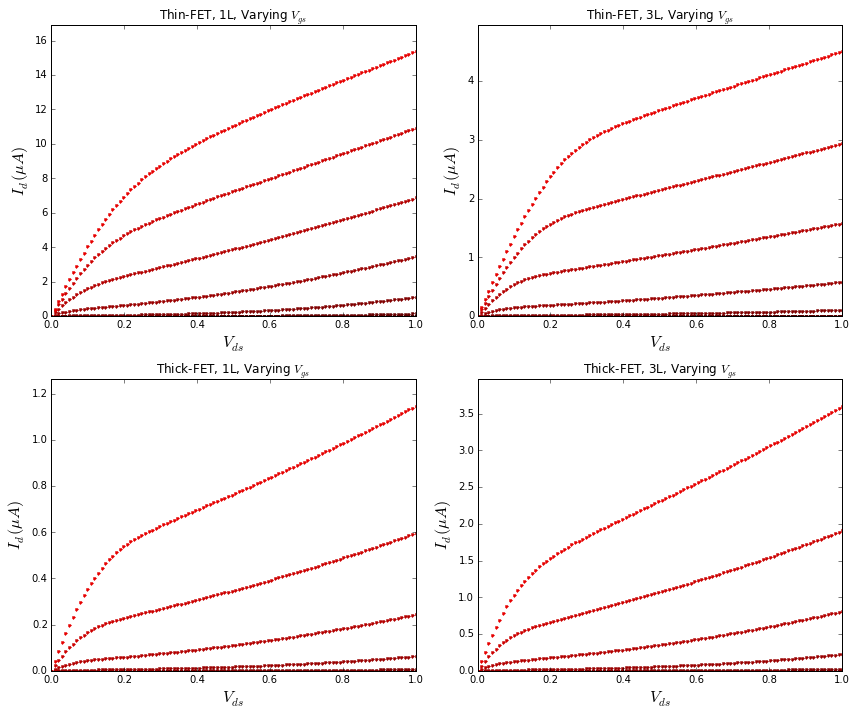

In [25]:
figsize(12,10)
subplot(2,2,1)
plotIds((origVds_1L, origIds_1L_Vds*1e6),
        ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,2)
plotIds((origVds_3L, origIds_3L_Vds*1e6),
        ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,3)
plotIds((origVds_eg1L, origIds_eg1L_Vds*1e6),
        ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,4)
plotIds((origVds_eg3L, origIds_eg3L_Vds*1e6),
        ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
tight_layout()
show()

### Plot $I_{ds}$ vs $V_{ds}$ Log Scale

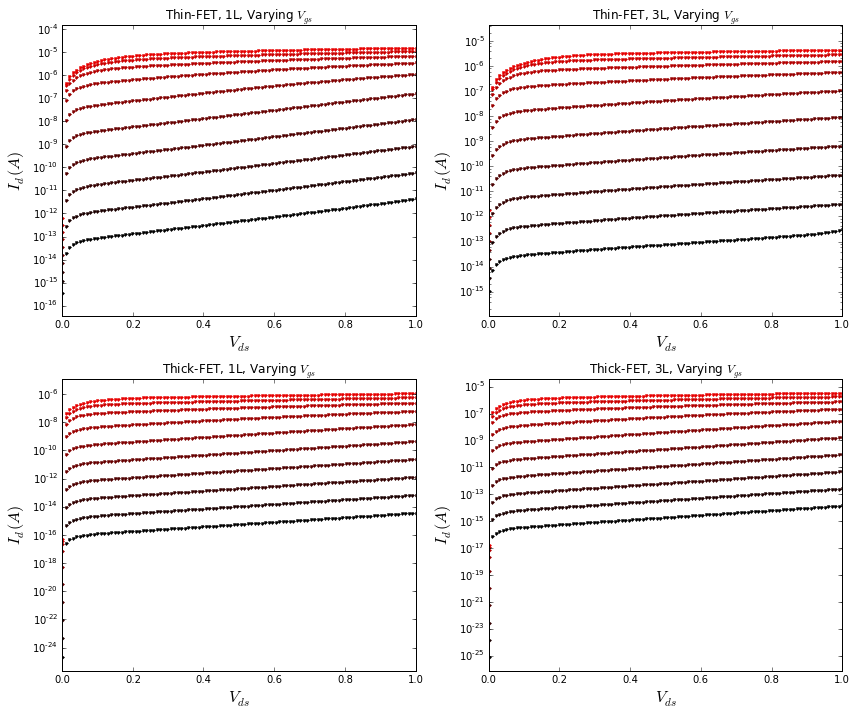

In [26]:
figsize(12,10)
subplot(2,2,1)
plotlogIds((origVds_1L, origIds_1L_Vds), ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$')
subplot(2,2,2)
plotlogIds((origVds_3L, origIds_3L_Vds), ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$')
subplot(2,2,3)
plotlogIds((origVds_eg1L, origIds_eg1L_Vds), ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$')
subplot(2,2,4)
plotlogIds((origVds_eg3L, origIds_eg3L_Vds), ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$')
tight_layout()
show()

### Plot $I_{ds}$ vs $V_{gs}$

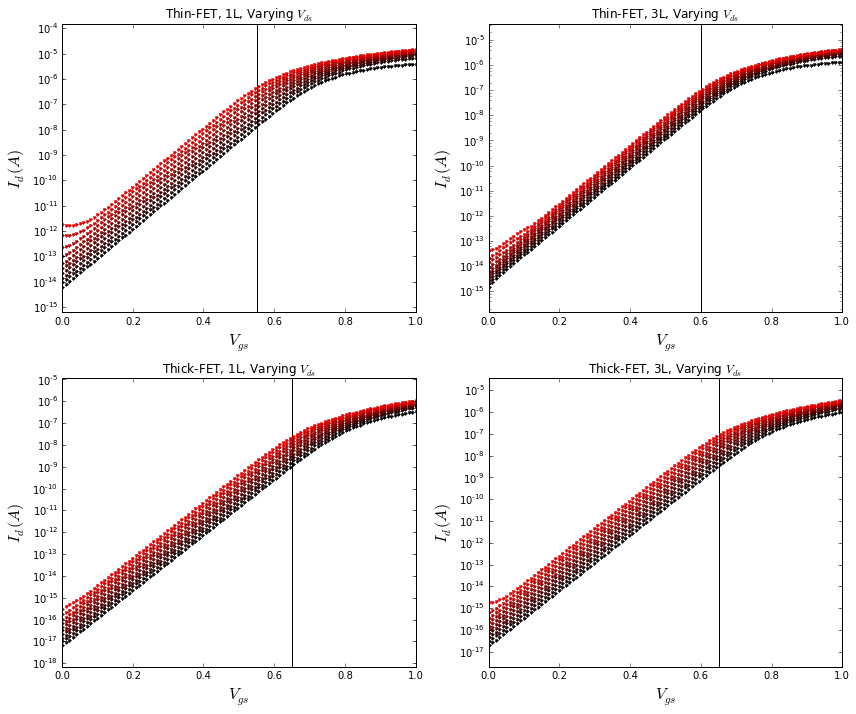

In [31]:
figsize(12,10)
subplot(2,2,1)
plotlogIds((origVgs_1L, origIds_1L_Vgs), ttl="Thin-FET, 1L, Varying $V_{ds}$", xlbl=r'$V_{gs}$')
fitTH_hi_1L_Vgs = 0.55
vlines(fitTH_hi_1L_Vgs, origIds_1L_Vgs.min()/10, origIds_1L_Vgs.max()*10)

subplot(2,2,2)
plotlogIds((origVgs_3L, origIds_3L_Vgs), ttl="Thin-FET, 3L, Varying $V_{ds}$", xlbl=r'$V_{gs}$')
fitTH_hi_3L_Vgs = 0.6
vlines(fitTH_hi_3L_Vgs, origIds_3L_Vgs.min()/10, origIds_3L_Vgs.max()*10)

subplot(2,2,3)
plotlogIds((origVgs_eg1L, origIds_eg1L_Vgs), ttl="Thick-FET, 1L, Varying $V_{ds}$", xlbl=r'$V_{gs}$')
fitTH_hi_eg1L_Vgs = 0.65
vlines(fitTH_hi_eg1L_Vgs, origIds_eg1L_Vgs.min()/10, origIds_eg1L_Vgs.max()*10)

subplot(2,2,4)
plotlogIds((origVgs_eg3L, origIds_eg3L_Vgs), ttl="Thick-FET, 3L, Varying $V_{ds}$", xlbl=r'$V_{gs}$')
fitTH_hi_eg3L_Vgs = 0.65
vlines(fitTH_hi_eg3L_Vgs, origIds_eg3L_Vgs.min()/10, origIds_eg3L_Vgs.max()*10)

tight_layout()
show()

### Plot $\kappa$

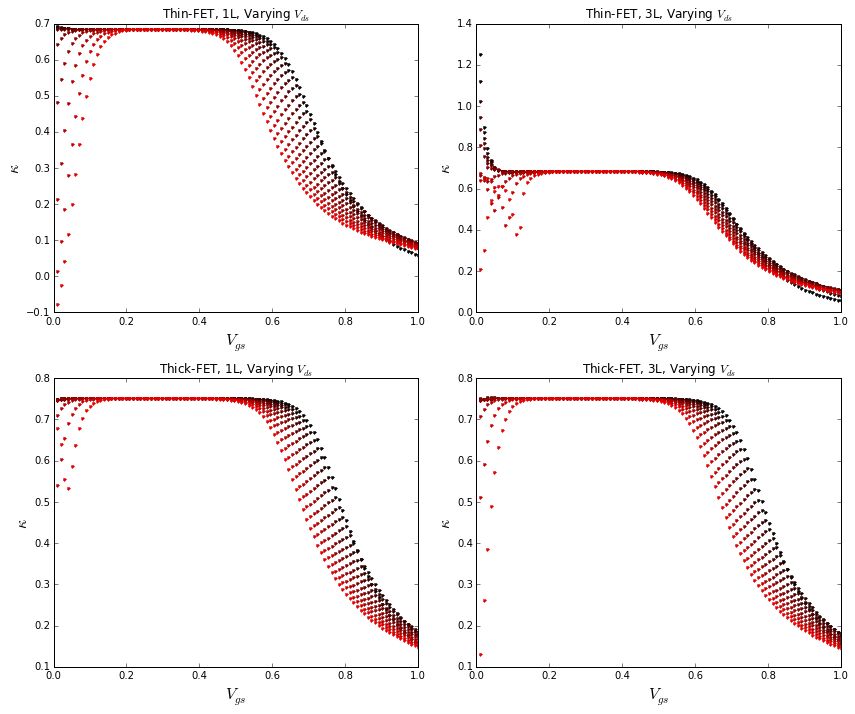

In [28]:
figsize(12,10)
subplot(2,2,1)
plotKappa((origVgs_1L, origIds_1L_Vgs), ttl="Thin-FET, 1L, Varying $V_{ds}$")
subplot(2,2,2)
plotKappa((origVgs_3L, origIds_3L_Vgs), ttl="Thin-FET, 3L, Varying $V_{ds}$")
subplot(2,2,3)
plotKappa((origVgs_eg1L, origIds_eg1L_Vgs), ttl="Thick-FET, 1L, Varying $V_{ds}$")
subplot(2,2,4)
plotKappa((origVgs_eg3L, origIds_eg3L_Vgs), ttl="Thick-FET, 3L, Varying $V_{ds}$")
tight_layout()
show()

### Find and Plot the Early Voltages

Early Voltages:	[ 0.57374928  0.55801211  0.55763833  0.55695228  0.54524227  0.44718937
  0.20592102 -0.12646744 -0.48686298 -0.81942739]
Early Voltages:	[ 0.42616193  0.31496819  0.31418039  0.31387577  0.30692468  0.23319411
 -0.03608325 -0.43090351 -0.85801294 -1.27999869]
Early Voltages:	[ 0.52536942  0.52382804  0.5238747   0.52383523  0.52258664  0.50341545
  0.38248414  0.13696858 -0.16101409 -0.47107905]
Early Voltages:	[ 0.54209401  0.54067856  0.54073076  0.5406965   0.53958755  0.52119039
  0.39981907  0.16160113 -0.10618588 -0.36763387]


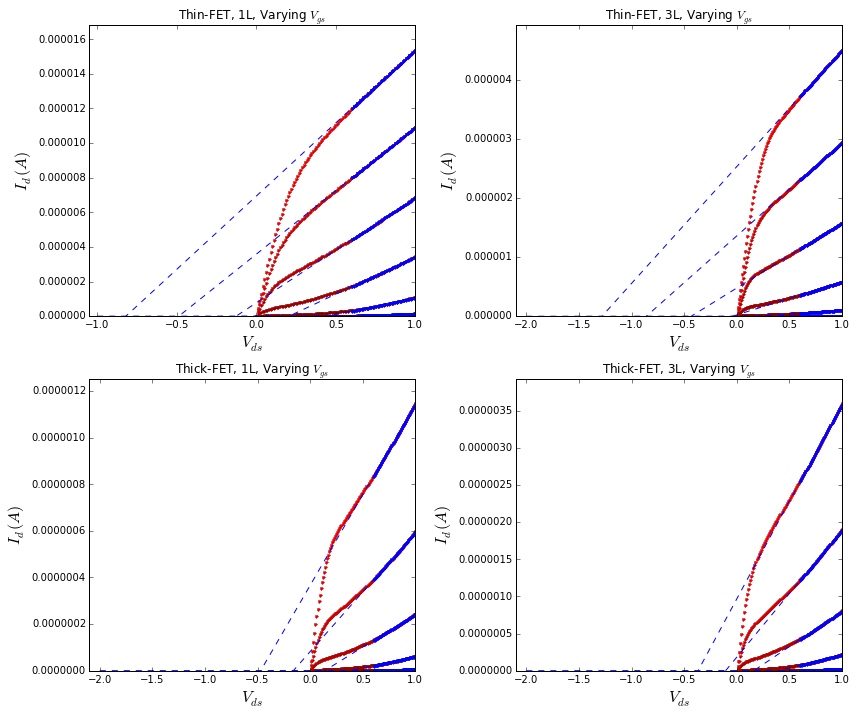

In [29]:
threshold = 0.6

figsize(12,10)
subplot(2,2,1)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_1L, origIds_1L_Vds, threshold)
plotIds((origVds_1L, origIds_1L_Vds), ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -1)

subplot(2,2,2)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_3L, origIds_3L_Vds, threshold)
plotIds((origVds_3L, origIds_3L_Vds), ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -2)

subplot(2,2,3)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg1L, origIds_eg1L_Vds, threshold)
plotIds((origVds_eg1L, origIds_eg1L_Vds), ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -2)

subplot(2,2,4)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg3L, origIds_eg3L_Vds, threshold)
plotIds((origVds_eg3L, origIds_eg3L_Vds), ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -2)

tight_layout()
show()

# Appendix

## Fit the subthreshold region for parameters

In [30]:
temp = 25
print Vds
print xData
print yData

popt, pcov = leastsq(Ids_PFET_Err, (0.7, 0.6, -9, 0.05), args=(xData, yData, Vds, temp))
kappa = popt[0]
gam = popt[1]
Kd = popt[2]
lamda = popt[3]

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


NameError: name 'xData' is not defined